In [1]:
] activate ../ 

In [187]:
using Revise
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using GridInterpolations

using POMDPPolicies

using JLD2
using FileIO
using Reel
using Random
using POMDPs
using POMDPModelTools
using LinearAlgebra

using PedestrianAvoidancePOMDP
using EmergencyBrakingSystem

In [465]:


#algorithm = "EmergencyBrakingSystem"
algorithm = "PedestrianAvoidancePOMDP"
algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"

policy = load("../policy/policy.jld2")["policy"];

# Definition ego vehicle and pedestrian behavior
scenarios = ["CPCN", "CPAN25", "CPAN75", "CPFA", "FP"]
vut_speeds = [10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]
vut_speeds = vut_speeds / 3.6
hit_points = [0., 10., 20., 30., 40., 50.]

probability_pedestrian_birth = 0.95


ego_v = vut_speeds[9]
hit_point = hit_points[1]
scenario = scenarios[2]


ego_vehicle = []
ego_a = [] 
collision = []
belief = []
action_pomdp = []
collision_rate = []
ttc = []
risk = []
emergency_brake_request = []
prediction_obstacle = []

### Simulate scenario with parameters above defined
# generate scenario based on scenario type
(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, scenario_id) = PedestrianAvoidancePOMDP.generate_scenario(scenario, ego_v, hit_point)
#println(ego_x, " ", ego_y, " ", ego_v, " ", ped_x," ",  ped_y," ",  ped_v)

## pedestrian is not in critical region
#ped_y = 10.
#ped_v = 0.

# simulate scenario
if (algorithm == "EmergencyBrakingSystem")
    (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = EmergencyBrakingSystem.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles)
else
    (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth)
end
#evaluate result
(collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenarioMetric(ego_vehicle, emergency_brake_request, ego_a, collision, ped_x)



PedestrianAvoidancePOMDP_EmergencyBrakingSystem


(false, false, 0.0, 6.5121172353455865, -2.909090909090909, 45.0, -4.0)

In [466]:
# Visualize scenario
cam = StaticCamera(VecE2(95.0,0.0),15.0)
#cam = CarFollowCamera(1,10.0)

if (algorithm == "EmergencyBrakingSystem")
    duration, fps, render_hist = EmergencyBrakingSystem.animate_record(rec, timestep, env, ego_vehicle, sensor, sensor_observations, risk, ttc, collision_rate, emergency_brake_request, prediction_obstacle, cam)
else
    duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, prediction_obstacle, cam)
end

film = roll(render_hist, fps = fps, duration = duration)
#write("CPAN_PedestrianAvoidancePOMDP.mp4", film) # Write to a webm video


Frames{MIME{Symbol("image/png")}}("/tmp/tmpTEPX7v", 0x00000000000000f1, 20.0, nothing)

In [481]:
# Evaluate EuroNCAP scenarios

using CSV
using DataFrames


algorithm = "EmergancyBrakingSystem"
#algorithm = "PedestrianAvoidancePOMDP"
#algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"

policy_name = "no"
#policy_name = "longitudinal_support"
#policy_name = "longitudinal_lateral_support"
policy = load("../policy/policy.jld2")["policy"];


log_filename = string("results_", algorithm, "_", policy_name, ".csv")

println(log_filename)

scenarios = ["CPCN", "CPAN25", "CPAN75", "CPFA", "FP"]
vut_speeds = [10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]
#vut_speeds = [50.]
vut_speeds = vut_speeds / 3.6

probability_pedestrian_birth = 0.95


println("Algorithm to evaluate: ", algorithm, " Policy: ", policy_name, " (if specified)")

# Evaluate all EuroNCAP scenarios
rec, timestep, env, ego_vehicle, sensor, sensor_observations, risk, ttc, collision_rate, emergency_brake_request, prediction_obstacle, collision, ego_a
results = Vector[]
for scenario in scenarios
    if (scenario == "FP") 
        hit_points = [-100., 200.]
    else
        hit_points = [0., 10., 20., 30., 40., 50.]
    end
    for hit_point in hit_points
        for vut_speed in vut_speeds
            ego_v = vut_speed
            (ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, scenario_id) = PedestrianAvoidancePOMDP.generate_scenario(scenario, ego_v, hit_point)
            if algorithm == "EmergancyBrakingSystem"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = EmergencyBrakingSystem.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles)
            elseif algorithm == "PedestrianAvoidancePOMDP"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth)
            elseif algorithm == "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth)
            else
                println("No valid algorithm defined!")
                return false
            end
            println(scenario, " HP: ", hit_point, " ", ego_x, " ", ego_y, " ", ego_v, " ", ped_x," ",  ped_y," ",  ped_v)
            (collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenarioMetric(ego_vehicle, emergency_brake_request, ego_a, collision, ped_x)
            println("Collision: ", collision, " eb: ", emergency_brake_intervention, " ", dv_collision, " ", v_mean, " ", a_mean, " ", a_jerk, " ", a_min)
            result = [scenario_id, ego_v, hit_point, collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min  ]
            push!(results, result)
        end
    end 
end  


# store results from scneario evaluation in log file
df = DataFrame(results)
df = DataFrame(Matrix(df)')
rename!(df, :x1 => :scenario_id, :x2 => :ego_v, :x3 => :hit_point, :x4 => :collision, :x5 => :eb_intervention)
rename!(df, :x6 => :dv_collision, :x7 => :v_mean, :x8 => :a_mean, :x9 => :a_jerk, :x10 => :a_min)

CSV.write(log_filename, df);

(sum_collisions, sum_eb, dv, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenariosMetric(results)

println("#collisions: ", sum_collisions, " #emergency brake interventions: ", sum_eb, " dv_m: ", dv, " v_mean: ", v_mean, " a_mean: ", a_mean, " a_jerk: ", a_jerk, " a_min: ", a_min)

df


results_EmergancyBrakingSystem_no.csv
Algorithm to evaluate: EmergancyBrakingSystem Policy: no (if specified)
CPCN HP: 0.0 89.66666666666667 0.0 2.7777777777777777 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: true 0.0 2.612599206349203 -8.125 20.0 -10.0
CPCN HP: 0.0 85.5 0.0 4.166666666666667 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: true 0.0 3.8958333333333295 -8.5 20.0 -10.0
CPCN HP: 0.0 81.33333333333334 0.0 5.555555555555555 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: true 0.0 5.398775894538599 -8.846153846153847 20.0 -10.0
CPCN HP: 0.0 77.16666666666666 0.0 6.944444444444445 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: true 0.0 6.186752136752145 -9.0625 20.0 -10.0
CPCN HP: 0.0 73.0 0.0 8.333333333333334 100.0 -5.066666666666666 1.3888888888888888
Collision: true eb: true 6.083333333333334 8.261299435028242 -7.857142857142857 10.0 -10.0
CPCN HP: 0.0 68.83333333333334 0.0 9.722222222222221 100.0 -5.0

CPCN HP: 40.0 73.0 0.0 8.333333333333334 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 7.2512437810945185 -9.210526315789474 20.0 -10.0
CPCN HP: 40.0 68.83333333333334 0.0 9.722222222222221 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 8.391339869281039 -9.285714285714286 20.0 -10.0
CPCN HP: 40.0 64.66666666666667 0.0 11.11111111111111 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 9.378968253968239 -9.375 20.0 -10.0
CPCN HP: 40.0 60.5 0.0 12.5 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 10.742753623188406 -9.444444444444445 20.0 -10.0
CPCN HP: 40.0 56.33333333333333 0.0 13.88888888888889 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 11.968599033816442 -9.5 20.0 -10.0
CPCN HP: 40.0 52.16666666666667 0.0 15.277777777777777 100.0 -4.346666666666666 1.3888888888888888
Collision: false eb: true 0.0 12.071111111111138 -9.545454545454545 20.0 -10.0
CPCN

CPAN25 HP: 20.0 48.0 0.0 16.666666666666668 100.0 -4.706666666666666 1.3888888888888888
Collision: false eb: true 0.0 13.033333333333314 -9.571428571428571 20.0 -10.0
CPAN25 HP: 30.0 89.66666666666667 0.0 2.7777777777777777 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: true 0.0 2.6095959595959566 -8.125 20.0 -10.0
CPAN25 HP: 30.0 85.5 0.0 4.166666666666667 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: true 0.0 3.8912429378531037 -8.5 20.0 -10.0
CPAN25 HP: 30.0 81.33333333333334 0.0 5.555555555555555 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: true 0.0 5.219489981785057 -8.846153846153847 20.0 -10.0
CPAN25 HP: 30.0 77.16666666666666 0.0 6.944444444444445 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: true 0.0 6.186752136752145 -9.0625 20.0 -10.0
CPAN25 HP: 30.0 73.0 0.0 8.333333333333334 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: true 0.0 7.2512437810945185 -9.210526315789474 20.0 -10.0
CP

CPAN75 HP: 10.0 68.83333333333334 0.0 9.722222222222221 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 8.391339869281039 -9.285714285714286 20.0 -10.0
CPAN75 HP: 10.0 64.66666666666667 0.0 11.11111111111111 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 9.378968253968239 -9.375 20.0 -10.0
CPAN75 HP: 10.0 60.5 0.0 12.5 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 10.742753623188406 -9.444444444444445 20.0 -10.0
CPAN75 HP: 10.0 56.33333333333333 0.0 13.88888888888889 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 11.968599033816442 -9.5 20.0 -10.0
CPAN75 HP: 10.0 52.16666666666667 0.0 15.277777777777777 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 12.071111111111138 -9.545454545454545 20.0 -10.0
CPAN75 HP: 10.0 48.0 0.0 16.666666666666668 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: true 0.0 13.033333333333314 -9.571428571428571 20

CPAN75 HP: 50.0 48.0 0.0 16.666666666666668 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: true 0.0 13.033333333333314 -9.571428571428571 20.0 -10.0
CPFA HP: 0.0 89.66666666666667 0.0 2.7777777777777777 100.0 -7.566666666666667 2.2222222222222223
Collision: false eb: true 0.0 2.6095959595959566 -8.125 20.0 -10.0
CPFA HP: 0.0 85.5 0.0 4.166666666666667 100.0 -7.566666666666667 2.2222222222222223
Collision: false eb: true 0.0 3.8958333333333295 -8.5 20.0 -10.0
CPFA HP: 0.0 81.33333333333334 0.0 5.555555555555555 100.0 -7.566666666666667 2.2222222222222223
Collision: false eb: true 0.0 5.06362007168458 -8.846153846153847 20.0 -10.0
CPFA HP: 0.0 77.16666666666666 0.0 6.944444444444445 100.0 -7.566666666666667 2.2222222222222223
Collision: false eb: true 0.0 6.186752136752145 -9.0625 20.0 -10.0
CPFA HP: 0.0 73.0 0.0 8.333333333333334 100.0 -7.566666666666667 2.2222222222222223
Collision: false eb: true 0.0 7.2512437810945185 -9.210526315789474 20.0 -10.0
CPFA HP: 0.0 68.83

CPFA HP: 40.0 68.83333333333334 0.0 9.722222222222221 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 8.391339869281039 -9.285714285714286 20.0 -10.0
CPFA HP: 40.0 64.66666666666667 0.0 11.11111111111111 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 9.378968253968239 -9.375 20.0 -10.0
CPFA HP: 40.0 60.5 0.0 12.5 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 10.742753623188406 -9.444444444444445 20.0 -10.0
CPFA HP: 40.0 56.33333333333333 0.0 13.88888888888889 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 11.968599033816442 -9.5 20.0 -10.0
CPFA HP: 40.0 52.16666666666667 0.0 15.277777777777777 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 12.071111111111138 -9.545454545454545 20.0 -10.0
CPFA HP: 40.0 48.0 0.0 16.666666666666668 100.0 -6.846666666666667 2.2222222222222223
Collision: false eb: true 0.0 13.033333333333314 -9.571428571428571 20.0 -10.0
CPF

,scenario_id,ego_v,hit_point,collision,eb_intervention,dv_collision,v_mean,a_mean,a_jerk,a_min
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,2.77778,0.0,0.0,1.0,0.0,2.6126,-8.125,20.0,-10.0
2,1.0,4.16667,0.0,0.0,1.0,0.0,3.89583,-8.5,20.0,-10.0
3,1.0,5.55556,0.0,0.0,1.0,0.0,5.39878,-8.84615,20.0,-10.0
4,1.0,6.94444,0.0,0.0,1.0,0.0,6.18675,-9.0625,20.0,-10.0
5,1.0,8.33333,0.0,1.0,1.0,6.08333,8.2613,-7.85714,10.0,-10.0
6,1.0,9.72222,0.0,1.0,1.0,4.47222,9.38616,-8.84615,10.0,-10.0
7,1.0,11.1111,0.0,1.0,1.0,8.86111,11.0391,-7.85714,10.0,-10.0
8,1.0,12.5,0.0,1.0,1.0,8.75,12.2917,-8.5,10.0,-10.0
9,1.0,13.8889,0.0,1.0,1.0,10.6389,13.7347,-8.33333,10.0,-10.0


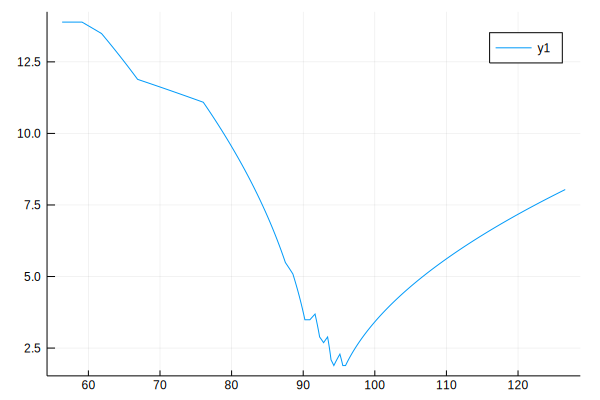

In [480]:

# velocity profile ego vehicle
using Plots
v = [] 
x = []
push!(v, ego_vehicle[2].state.v)
push!(x, ego_vehicle[2].state.posG.x)

for i=2:length(ego_vehicle)
    v_tmp = v[end]*0.0 + 1.0*ego_vehicle[i].state.v
    push!(v, v_tmp) 
    push!(x, ego_vehicle[i].state.posG.x)
end
plot(x,v)